In [10]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
from torchvision import transforms

from cotatenis_sneakers.sneaker_dataset import SneakerDataset
from cotatenis_sneakers.sneaker_transforms import (
    get_transform_notebook,
    UnNormalize,
    PadToSize,
)

In [11]:
_download_ = False
folder = "data/public"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
print("device:", device)

device: cuda


## 1 - Data download and import

In [13]:
if _download_:
    os.system("python download_data.py")
    os.system("python data/prepare_data.py")

In [14]:
transform = get_transform_notebook()

In [15]:
train_data = pd.read_csv(f"{folder}/train/train.csv")
train_dataset = SneakerDataset(
    train_data, folder=f"{folder}/train", device=device, transform=transform
)
test_data = pd.read_csv(f"{folder}/test/test.csv")
test_dataset = SneakerDataset(
    test_data, folder=f"{folder}/test", device=device, transform=transform
)

In [16]:
train_dataset[0]

(tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ...,

In [17]:
len(train_dataset), len(test_dataset)

(6971, 2988)

## 2 - Data Visualization

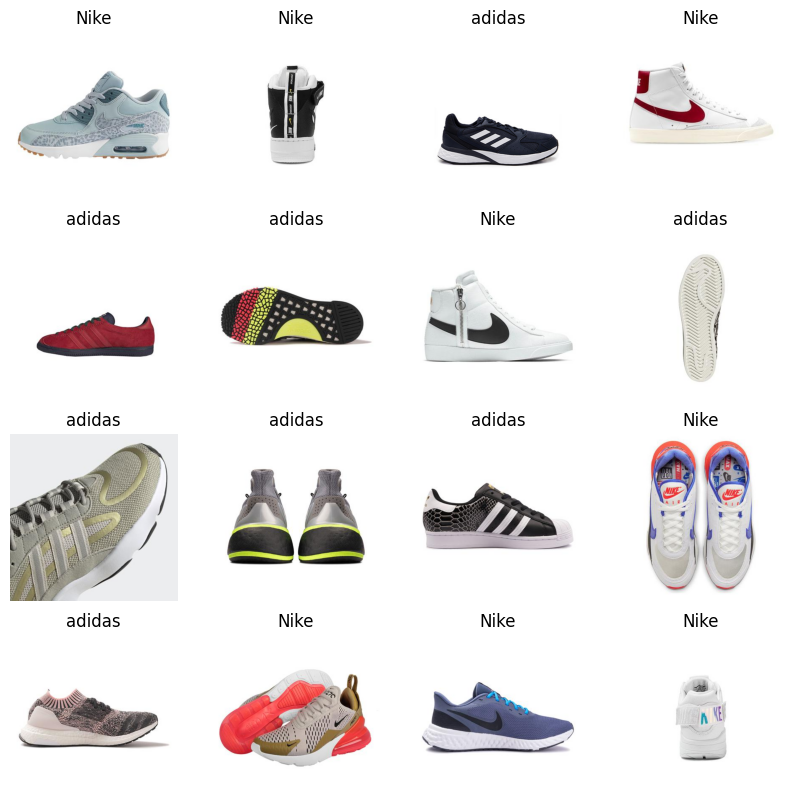

In [18]:
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        rint = np.random.randint(train_dataset.data.shape[0])
        img, brand = train_dataset.get_untransformed_tuple(rint)
        ax[i, j].imshow(img)
        ax[i, j].set_title(brand)
        ax[i, j].axis("off")
plt.show()

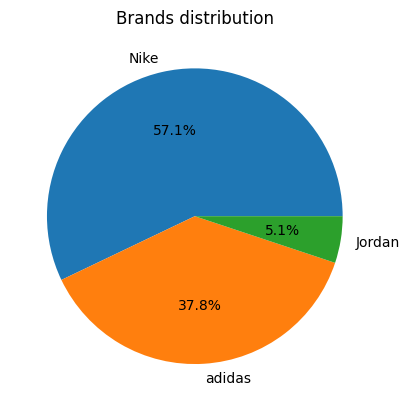

In [19]:
# labels distribution
brands = train_dataset.labels.value_counts()
plt.pie(brands, labels=brands.index, autopct="%1.1f%%")
plt.title("Brands distribution")
plt.show()

In [20]:
print(
    "All images have the same dimensions:",
    all(
        [
            train_dataset.get_untransformed_tuple(i)[0].size
            == train_dataset.get_untransformed_tuple(0)[0].size
            for i in range(len(train_dataset))
        ]
    ),
)

d:\COURS\A5\Datacamp\ramp-kits-cotatenis-sneakers\cotatenis_venv\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


All images have the same dimensions: False


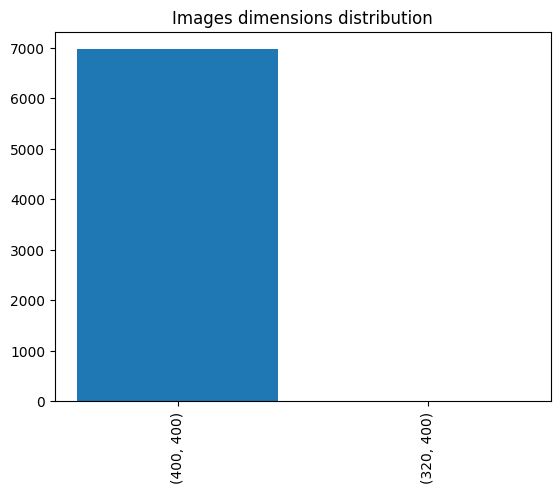

In [21]:
sizes = [
    str(train_dataset.get_untransformed_tuple(i)[0].size)
    for i in range(len(train_dataset))
]


sizes = pd.Series(sizes).value_counts()


plt.bar(sizes.index, sizes.values)


plt.xticks(rotation=90)


plt.title("Images dimensions distribution")


plt.show()

## 3 - Data Preprocessing

Preprocessing is done thanks to the `transform` parameter of the sneaker dataset. You can find the details of each step in `cotanis_sneakers/sneaker_transforms.py`. We pad images so they are the same size, and also normalise them.

Text(0.5, 1.0, 'Transformed image\nwith denormalisation')

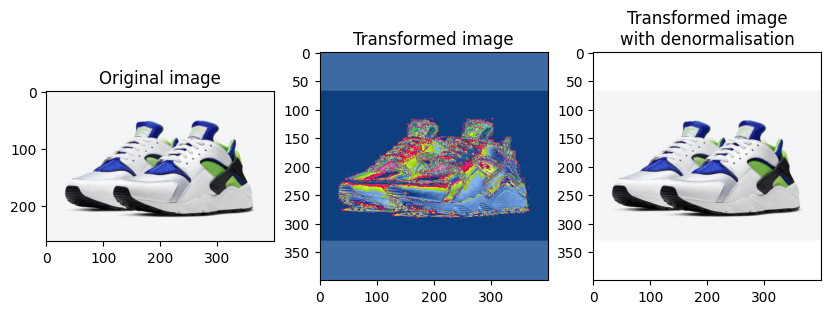

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(test_dataset.get_untransformed_tuple(752)[0])
axs[0].set_title("Original image")

axs[1].imshow(F.to_pil_image(test_dataset[752][0]))
axs[1].set_title("Transformed image")

unnorm = UnNormalize()
axs[2].imshow(F.to_pil_image(unnorm(test_dataset[752][0])))
axs[2].set_title("Transformed image\nwith denormalisation")

## 4 - Training

In [23]:
if device == "cuda":
    train_loader = DataLoader(
        train_dataset, batch_size=32, shuffle=True, pin_memory=True
    )
else:
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [24]:
# load a pretrained model for image classification
model = torch.hub.load("pytorch/vision", "mobilenet_v2", pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier[1] = torch.nn.Linear(model.last_channel, 3)

for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

Using cache found in C:\Users\orteg/.cache\torch\hub\pytorch_vision_main
d:\COURS\A5\Datacamp\ramp-kits-cotatenis-sneakers\cotatenis_venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\COURS\A5\Datacamp\ramp-kits-cotatenis-sneakers\cotatenis_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\orteg/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 39.7MB/s]


In [25]:
# fine-tune the model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 5
print_every = 100
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % print_every == 0 and i != 0:
            print(f"Epoch : {epoch}, Iteration : {i}, Loss: {running_loss / 10:.3f}")
            running_loss = 0.0

Epoch : 0, Iteration : 100, Loss: 7.984


d:\COURS\A5\Datacamp\ramp-kits-cotatenis-sneakers\cotatenis_venv\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch : 0, Iteration : 200, Loss: 6.976
Epoch : 1, Iteration : 100, Loss: 6.374
Epoch : 1, Iteration : 200, Loss: 6.435
Epoch : 2, Iteration : 100, Loss: 5.895
Epoch : 2, Iteration : 200, Loss: 5.904
Epoch : 3, Iteration : 100, Loss: 5.922
Epoch : 3, Iteration : 200, Loss: 5.726
Epoch : 4, Iteration : 100, Loss: 5.673
Epoch : 4, Iteration : 200, Loss: 5.664


## 5 - Prediction

In [26]:
if device == "cuda":
    test_loader = DataLoader(
        test_dataset, batch_size=32, shuffle=False, pin_memory=True
    )
else:
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [27]:
model.eval()
correct = 0
total_correct = 0
total = 0


print_every = 10

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.max(labels, 1)[1]).sum().item()

        if i % print_every == 0 and i != 0:
            print(f"Iteration {i}, accuracy: {correct / total}")
            total_correct += correct
            correct = 0
            total = 0


print("Total correct", total_correct)
print("Total images", test_dataset.data.shape[0])
accuracy = total_correct / test_dataset.data.shape[0]
print(f"Test Accuracy: {accuracy}")

Iteration 10, accuracy: 0.09943181818181818
Iteration 20, accuracy: 0.075
Iteration 30, accuracy: 0.103125
Iteration 40, accuracy: 0.090625
Iteration 50, accuracy: 0.06875
Iteration 60, accuracy: 0.078125
Iteration 70, accuracy: 0.08125
Iteration 80, accuracy: 0.084375
Iteration 90, accuracy: 0.096875
Total correct 252
Total images 2988
Test Accuracy: 0.08433734939759036


## 6 - Test your model

In [28]:
! ramp-test --submission starting_kit

Testing Sneakers brand classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions\starting_kit ...
CV fold 0
	score  bal_acc    acc        time
	train    0.317  0.519    1.564287
	valid    0.325  0.533  100.668114
	test     0.325  0.531   43.161463
----------------------------
Mean CV scores
----------------------------
	score      bal_acc          acc         time
	train  0.317 ± 0.0  0.519 ± 0.0    1.6 ± 0.0
	valid  0.325 ± 0.0  0.533 ± 0.0  100.7 ± 0.0
	test   0.325 ± 0.0  0.531 ± 0.0   43.2 ± 0.0
----------------------------
Bagged scores
----------------------------
	score  bal_acc    acc
	valid    0.326  0.533
	test     0.324  0.529


Using cache found in C:\Users\orteg/.cache\torch\hub\pytorch_vision_main
D:\COURS\A5\Datacamp\ramp-kits-cotatenis-sneakers\cotatenis_venv\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
